### visualize the data

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# use seaborn plotting defaults
import seaborn as sns; sns.set()
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle


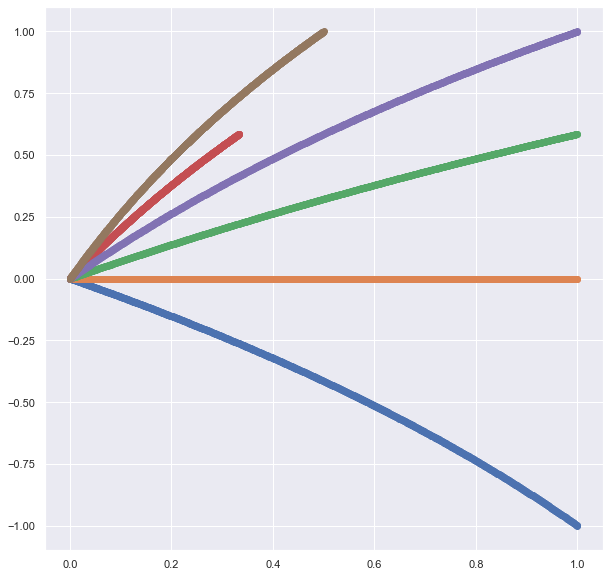

In [19]:
x = np.linspace(0,1,1000)
x3 = np.linspace(0, 1/3, 1000)
x4 = np.linspace(0, 1/2, 1000)

fig, ax = plt.subplots(figsize=(10,10))
#LOH
_ = ax.scatter(x,np.log2(2-x)-1)
# N=2
_ = ax.scatter(x,np.zeros(x.shape[0]))
# N=3
_ = ax.scatter(x,np.log2(2+x)-1)
_ = ax.scatter(x3,np.log2(2+3*x3)-1)
# N=4
_ = ax.scatter(x,np.log2(1+x))
_ = ax.scatter(x4,np.log2(1+2*x4))

In [15]:
def sort_df(df):
    '''
    helper for sorting dfs for chromosomes
    '''
    df2 = df.copy()
    # make Chr column categorical for sorting .. and sort
    chrom_list = [f"chr{i+1}" for i in range(22)] + ['chrX']
    df2['Chr'] = pd.Categorical(df2['Chr'], chrom_list)
    return df2.sort_values(['Chr', 'FullExonPos'])


def get_chrom_df(df):

    # dropna is neccessary because grouping on categorical returns all categories
    chrom_df = df.groupby('Chr')['FullExonPos'].agg(['mean', 'min', 'max']).dropna()
    cols = list(chrom_df.columns)
    chrom_df['sum'] = chrom_df['max'] - chrom_df['min']
    chrom_df['cummin'] = chrom_df['sum'].cumsum()
    chrom_df['dif'] = (chrom_df['max'] - chrom_df['cummin']).astype(int)
    for col in cols:
        chrom_df[col] = (chrom_df[col] - chrom_df['dif']).astype(int)
    cols.append('dif')
    return chrom_df.loc[:, cols]


def make_color_chroms(ax, chrom_df, color_chroms, ylimits=(-10,10), colormap='coolwarm_r'):
    
    # set the cmap from provided argument
    cmap = plt.cm.get_cmap(colormap, 23)
    
    # build the rects
    rects = []
    # set the height and ymin beyond the ylimits so borders are not seen
    ymin = ylimits[0] * 1.1
    height = (ylimits[1] - ymin) * 1.1
    
    for chrom in chrom_df.index:
        row = chrom_df.loc[chrom]
        rect = Rectangle((row['min'], ymin), width=row['max']-row['min'], height=height)
        rects.append(rect)

    if color_chroms:
        rect_kwargs = dict(
            alpha=.6,
            ec='none'
        )
    else:
        rect_kwargs = dict(
            alpha=1,
            fc='none',
            ec='darkgray',
            lw=1,
            ls='-'
        )
    # set the rectangle collection with colormap
    rect_collection = PatchCollection(rects, cmap=cmap, **rect_kwargs)
    # set the index for the color map from chrom integers
    rect_collection.set_array(chrom_df.index.str.replace('chr', '').str.replace('X', '23').astype(int))
    return ax.add_collection(rect_collection)


def add_chrom_labels(ax, chrom_df, ylimits=(-10,10)):
    
    # YOFFSET is the upper-relative y-position 
    YOFFSET = 0.9
    # get the min_chrom_fraction from minimum chrom_size / whole stretch
    min_chrom_frac = (chrom_df['max'] - chrom_df['min']).min() / chrom_df['max'].max()
    chrom_size = min(50, max(15, 200*min_chrom_frac))
    style = dict(size=chrom_size, color='#2f3832')
    # set the height and ymin beyond the ylimits so borders are not seen
    ypos = ylimits[0] + YOFFSET * (ylimits[1] - ylimits[0])
    for chrom, row in chrom_df.iterrows():
        if (len(chrom_df.index) > 12):
            chrom = chrom.replace('chr', '')
        ax.text(row['mean'], ypos, chrom, ha='center', **style)
    

def make_nice(position):
    '''
    takes position and returns closest multiple of 1, 2, 5 or 10
    '''
    # set nice values
    nice_positions = np.array([1,2,2.5,5,10])
    # get the 10s
    power10 = np.power(10, np.floor(np.log10(position)))
    # reduce to value between 1 and 10
    num = position / power10
    # find the closest nice position
    base = nice_positions[np.argmin(np.abs(nice_positions / num - 1))]
    return base * power10

def get_tick_pos(tick_dist, chrom_df):
    '''
    return from chrom_df the evenly-spread (tick_dist) positions per chrom
    '''
    return [pos for _, row in chrom_df.iterrows() for pos in range(row['min'] + tick_dist, row['max'], tick_dist)]


def str_pos(pos, df, precision=1):
    '''
    returns string representation of base position
    on genomic coords
    '''
    pos = df.iloc[np.argmin(np.abs(df['PlotPos'] - pos))]['Pos']
    # get the closest base power
    power10 = int(np.round(np.log10(pos) / 3) * 3)
    # get the base fraction
    base = pos / np.power(10, power10)
    if power10 == 9:
        base = base * 1000
        power10 = 6
    if power10 == 6:
        suff = 'Mb'
    elif power10 == 3:
        suff = 'kb'
    base = round(base,precision)
    if power10 == 0:
        suff = 'b'
        base = int(base)
    return f"{base}{suff}"


def set_ticks(ax, df, chrom_df, ticks=20, label_size=12):
    '''
    for a given tick number, set nicely spread ticks
    '''
    
    ## determine optimale tick distance
    # get the chrom_number
    chrom_count = len(chrom_df.index)
    # get the number of bases
    stretch = chrom_df['max'][-1]
    # set the number of desired ticks
    major_tick_dist = int(stretch / (ticks + 1))
    minor_tick_dist = int(stretch / ((ticks * 2) + 1))
    
    # feed tick distance into chrom_df to get chrom-specific coords
    major_pos = get_tick_pos(major_tick_dist, chrom_df)
    minor_pos = [pos - minor_tick_dist for pos in major_pos]
    
    ax.xaxis.set_major_locator(plt.FixedLocator(major_pos))
    # only print the genomic coords below a certain base total
    if stretch < 2e7:
        major_labels = [str_pos(pos, df) for pos in major_pos]
        ax.xaxis.set_major_formatter(plt.FixedFormatter(major_labels))
    else:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.xaxis.set_minor_locator(plt.FixedLocator(minor_pos))
    ax.xaxis.grid(which='major', linestyle='-', linewidth=2)
    ax.xaxis.grid(which='minor', linestyle='--', linewidth=1)
    ax.xaxis.set_tick_params(which='major', length=20, labelsize=label_size)
    ax.yaxis.set_tick_params(which='major', length=20, labelsize=label_size)
    # set the tick labels
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_verticalalignment("bottom")
    return ax


def extract_pos(region):
    
    def convert(pos):
        if pos.endswith('Mb'):
            pos = int(pos.replace('Mb', '')) * 1e6
        elif pos.endswith('kb'):
            pos = int(pos.replace('kb', '')) * 1000
        else:
            pos = int(pos)
        return pos
    
    split = region.split(':')  
    chrom = split[0]
    
    # if start and are used
    if len(split) > 1 and '-' in split[1]:     
        se = split[1].split('-')
        start = convert(se[0])
        end = convert(se[1])
    else:
        start = 0
        end = 1e10
    return chrom, start, end
    

def plot_genomic(df, plots, chroms='all', color_chroms=True, colormap='coolwarm_r', region='', figsize=(20,4), ylim=(-1,1), label_size=12):
    
    #### DATA MANGELING ##########
    # get cols for rearranging
    org_cols = list(df.columns)
    
    # sort the df
    df = sort_df(df)
    # reduce the df to the selected chromosomes
    if region:
        chrom, start, end = extract_pos(region)
        df = df.query('Chr == @chrom and @start <= Pos <= @end')
    elif chroms != 'all':
        df = df.query('Chr in @chroms')

    # get the chrom_df for collapsing the 
    chrom_df = get_chrom_df(df)
    
    df = df.merge(chrom_df.loc[:, 'dif'], on='Chr')
    df['PlotPos'] = df['FullExonPos'] - df['dif']
    
    # rearrange the df as return value
    new_cols = org_cols[:4] + ['PlotPos'] + org_cols[4:]
    df = df.loc[:, new_cols]
    

    ######## PLOTTING #######
    # plot the figure
    fig, ax = plt.subplots(figsize=figsize)

    # set the x-axis limits
    _ = ax.set_xlim(0, df['PlotPos'].max())
    
    # plot the graphs #######
    for plot in plots:
        if plot['plot_type'] == 'line':
            plot = ax.plot(df['PlotPos'],df[plot['data']], **plot['plot_args'])
        elif plot['plot_type'] == 'scatter':
            plot = ax.scatter(df['PlotPos'],df[plot['data']], **plot['plot_args'])
    
    _ = ax.set_ylim(ylim)
    # add the color chroms
    _ = make_color_chroms(ax, chrom_df, color_chroms, ylimits=ax.get_ylim(), colormap=colormap)
    
    
    ######## LABELS ###################
    # set the axis labels
    _ = ax.set_xlabel('genomic coords', fontsize=1.25*label_size);
    # quick fix for one y-label
    _ = ax.set_ylabel(' / '.join([plot['title'] for plot in plots]), fontsize=1.25*label_size)
    
    ######## CHROM LABELS #############
    add_chrom_labels(ax, chrom_df, ax.get_ylim())
    
    ####### X-AXIS ####################
    # set major ticks and grid for chrom
    
    ax = set_ticks(ax, df, chrom_df, label_size=label_size)
    
    # return fig and ax for further plotting and return edited dataframe
    return fig, ax, df, chrom_df


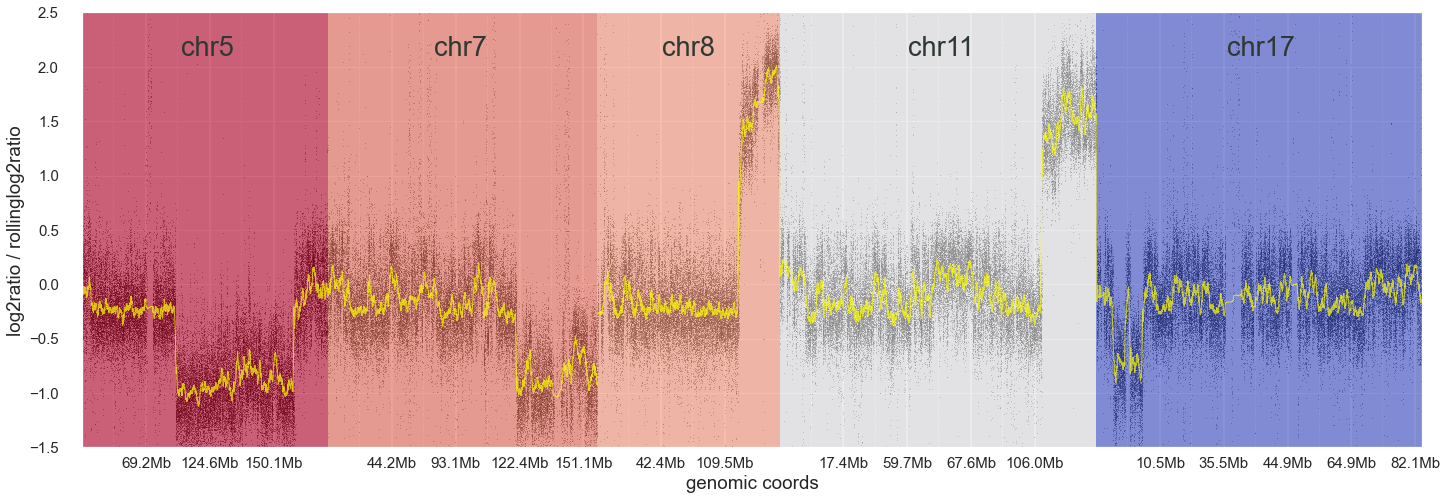

In [16]:
log2 = dict(
        title='log2ratio',
        plot_type='scatter',   # ['line', 'scatter']
        data='log2ratio',
        plot_args=dict(
            linewidth=0.3,
            color='black',
            s=0.2,
            alpha=.7
        )
    )

log2mean = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']

fig_params = dict(
    figsize=(24,8),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(-1.5,2.5),
    label_size=15
)

fig, ax, df, chrom_df = plot_genomic(cov_df, plots=[log2, log2mean], chroms=chroms, region='', **fig_params)

# visualize heteroSNP

In [17]:
sample = "01_A"
snp_df = pd.read_csv(os.path.join(output_path, f'rollingCNV/{sample}.snpcov.csv'), sep='\t')
snp_df

,Chr,Pos,FullExonPos,ExonPos,log2ratio,log2ratiomean,log2ratiomeanDiff,Depth,EBscore,VAF
0,chr1,14930,836,836,1.747734,0.161229,0.0,64.0,0.505,0.046875
1,chr1,15820,991,991,0.435176,0.161229,0.0,13.0,2.401,0.846154
2,chr1,16949,1410,1410,0.789243,0.161229,0.0,182.0,0.006,0.038462
3,chr1,17365,1689,1689,1.040816,0.161229,0.0,285.0,0.666,0.140351
4,chr1,17375,1699,1699,1.004858,0.161229,0.0,353.0,1.526,0.065156
...,...,...,...,...,...,...,...,...,...,...
336263,chrX,156023260,49469650,1835187,-0.667568,0.079280,0.0,25.0,0.950,0.880000
336264,chrX,156023266,49469656,1835193,-0.655721,0.079252,0.0,25.0,0.930,0.880000
336265,chrX,156024203,49469886,1835423,0.148033,0.078196,0.0,53.0,0.392,0.132075
336266,chrX,156024239,49469922,1835459,0.160322,0.078030,0.0,56.0,0.203,0.267857


### for hetSNP visualization:
    + covData is normalized to range 1 and pushed up 1.5
    + cov_vis is specified by cov_plots
    + snp_vis in specified by snp_plots

In [20]:
def plot_snp(df, snp_plots=[], cov_plots=[], chroms='all', cov_offset=.25, cov_height=0.5, color_chroms=True, colormap='coolwarm_r', region='', label_size=12, figsize=(20,4), ylim=(-1,1)):
    
    MAXLOG2RATIO = 2.5
    #### DATA MANGELING ##########
    # get cols for rearranging
    org_cols = list(df.columns)
    
    # sort the df
    df = sort_df(df)
    # reduce the df to the selected chromosomes
    if region:
        chrom, start, end = extract_pos(region)
        df = df.query('Chr == @chrom and @start <= Pos <= @end')
    elif chroms != 'all':
        df = df.query('Chr in @chroms')

    # get the chrom_df for collapsing the 
    chrom_df = get_chrom_df(df)
    
    df = df.merge(chrom_df.loc[:, 'dif'], on='Chr')
    df['PlotPos'] = df['FullExonPos'] - df['dif']
    
    # rearrange the df as return value
    new_cols = org_cols[:4] + ['PlotPos'] + org_cols[4:]
    df = df.loc[:, new_cols]
    
    #########################
    ######## PLOTTING #######
    # plot the figure
    fig, ax = plt.subplots(figsize=figsize)

    # set the x-axis limits
    _ = ax.set_xlim(0, df['PlotPos'].max())
    
    
    ######## PLOT COV Data
    
    if len(cov_plots):
        scale_factor = cov_height / (MAXLOG2RATIO + 1)
        offset = 1 + scale_factor + cov_offset

        ylim = (ylim[0], ylim[1] + cov_offset + cov_height)
        
        for plot in cov_plots:
            # normalize the coverage data:
            # 2.5 is the approx max log2ratio (LOH to 8N)

            df[plot['data']] = df[plot['data']] * scale_factor + offset
            if plot['plot_type'] == 'line':
                plot = ax.plot(df['PlotPos'],df[plot['data']], **plot['plot_args'])
            elif plot['plot_type'] == 'scatter':
                plot = ax.scatter(df['PlotPos'],df[plot['data']], **plot['plot_args'])
    
    ######## plot the SNP graphs #######
    for plot in snp_plots:
        if plot['plot_type'] == 'line':
            plot = ax.plot(df['PlotPos'],df[plot['data']], **plot['plot_args'])
        elif plot['plot_type'] == 'scatter':
            plot = ax.scatter(df['PlotPos'],df[plot['data']], **plot['plot_args'])
    
    _ = ax.set_ylim(ylim)
    # add the color chroms
    _ = make_color_chroms(ax, chrom_df, color_chroms, ylimits=ax.get_ylim(), colormap=colormap)
    
    
    ######## LABELS ###################
    # set the axis labels
    _ = ax.set_xlabel('genomic coords', fontsize=1.25*label_size);
    # quick fix for one y-label
    _ = ax.set_ylabel(' / '.join([plot['title'] for plot in snp_plots]), fontsize=1.25*label_size)
    
    ######## CHROM LABELS #############
    add_chrom_labels(ax, chrom_df, ax.get_ylim())
    
    ####### X-AXIS ####################
    # set major ticks and grid for chrom
    
    ax = set_ticks(ax, df, chrom_df, label_size=label_size)
    
    # return fig and ax for further plotting and return edited dataframe
    return fig, ax, df, chrom_df

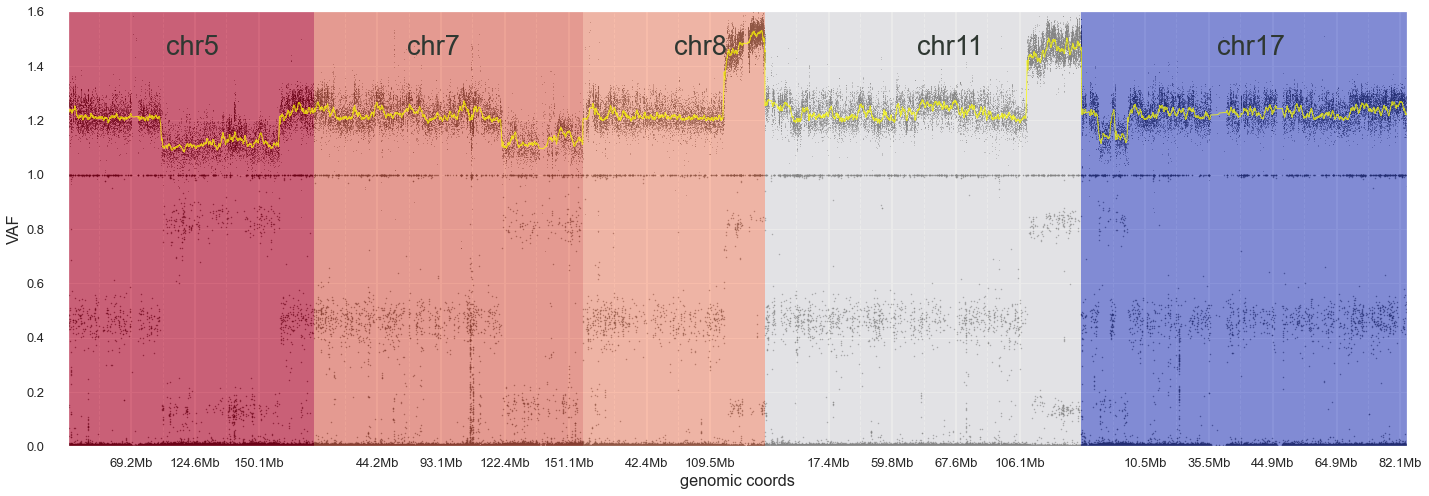

In [69]:
log2 = dict(
        title='log2ratio',
        plot_type='scatter',   # ['line', 'scatter']
        data='log2ratio',
        plot_args=dict(
            linewidth=0.3,
            color='black',
            s=0.2,
            alpha=.7
        )
    )

log2mean = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

vaf = dict(
        title='VAF',
        plot_type='scatter',  # ['line', 'scatter']
        data='VAF',
        plot_args=dict(
            s=.2,
            color='black',
            alpha=.7
        )
    )

fig_params = dict(
    figsize=(24,8),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(0,1),
    cov_offset=.1,  # how much log2ratio=0 is shifted above SNP-data
    cov_height=.5,
    label_size=13
)

fig, ax, df, chrom_df = plot_snp(snp_df, snp_plots=[vaf], cov_plots=[log2, log2mean], chroms=chroms, region='', **fig_params)

## visualize clusterings

### load example clustered file from DBscan clustering

In [79]:
sample = "01_A"
df = pd.read_csv(os.path.join(output_path, f'cluster/{sample}.dbscan.csv'), sep='\t')

In [80]:
df

,Chr,Pos,FullExonPos,ExonPos,log2ratio,log2ratiomean,log2ratiomeanDiff,Depth,EBscore,VAF,absVAF,deltaVAF,absVAFmean,absVAFmeanDiff,VAFstd,VAFstdDiff,deltaVAFvar,deltaVAFvarDiff,deltaVAFstd,deltaVAFstdDiff,dbscan
0,chr1,1054900,37368,37368,-0.069236,0.346636,3.945632e-03,147.0,0.044,0.421769,0.156462,0.056079,0.310983,0.0,0.178631,0.0,0.042368,0.0,0.205834,0.0,0
1,chr1,1055000,37468,37468,-0.066106,0.346110,3.457801e-03,98.0,0.919,0.489796,0.020408,0.068027,0.310983,0.0,0.178631,0.0,0.042368,0.0,0.205834,0.0,0
2,chr1,1055037,37505,37505,-0.031916,0.346188,3.524551e-03,86.0,0.840,0.476744,0.046512,0.013052,0.310983,0.0,0.178631,0.0,0.042368,0.0,0.205834,0.0,0
3,chr1,1071823,37706,37706,0.337613,0.346937,3.793557e-03,109.0,0.007,0.532110,0.064220,0.055366,0.310983,0.0,0.178631,0.0,0.042368,0.0,0.205834,0.0,0
4,chr1,1291377,55139,55139,0.242629,0.247084,8.714793e-10,182.0,1.818,0.445055,0.109890,0.087055,0.310983,0.0,0.178631,0.0,0.042368,0.0,0.205834,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24009,chrX,156023260,49469650,1835187,-0.667568,0.212712,0.000000e+00,25.0,0.950,0.880000,0.760000,0.023226,0.155058,0.0,0.141056,0.0,0.015260,0.0,0.123530,0.0,0
24010,chrX,156023266,49469656,1835193,-0.655721,0.212684,0.000000e+00,25.0,0.930,0.880000,0.760000,0.000000,0.155058,0.0,0.141056,0.0,0.015260,0.0,0.123530,0.0,0
24011,chrX,156024203,49469886,1835423,0.148033,0.211628,0.000000e+00,53.0,0.392,0.132075,0.735850,0.747925,0.155058,0.0,0.141056,0.0,0.015260,0.0,0.123530,0.0,0
24012,chrX,156024239,49469922,1835459,0.160322,0.211463,0.000000e+00,56.0,0.203,0.267857,0.464286,0.135782,0.155058,0.0,0.141056,0.0,0.015260,0.0,0.123530,0.0,0


In [81]:
log2 = dict(
        title='log2ratio',
        plot_type='scatter',   # ['line', 'scatter']
        data='log2ratio',
        plot_args=dict(
            linewidth=0.3,
            color='black',
            s=0.2,
            alpha=.7
        )
    )

log2mean = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

absvaf = dict(
        title='absVAF',
        plot_type='scatter',  # ['line', 'scatter']
        data='absVAF',
        plot_args=dict(
            s=1,
            c='dbscan',
            alpha=.7
        )
    )

absvafmean = dict(
        title='deltaVAFvar',
        plot_type='line',   # ['line', 'scatter']
        data='deltaVAFvar',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )

fig_params = dict(
    figsize=(24,8),
    colormap='coolwarm_r',
    color_chroms=False,
    ylim=(0,1),
    cov_offset=.1,  # how much log2ratio=0 is shifted above SNP-data
    cov_height=.5,
    label_size=13
)


### expand plot_snp functionality to showing clusters

In [82]:
def plot_snp(df, snp_plots=[], cov_plots=[], chroms='all', cov_offset=.25, cov_height=0.5, color_chroms=True, colormap='coolwarm_r', region='', label_size=12, figsize=(20,4), ylim=(-1,1)):
    
    MAXLOG2RATIO = 2.5
    #### DATA MANGELING ##########
    # get cols for rearranging
    org_cols = list(df.columns)
    
    # sort the df
    df = sort_df(df)
    # reduce the df to the selected chromosomes
    if region:
        chrom, start, end = extract_pos(region)
        df = df.query('Chr == @chrom and @start <= Pos <= @end')
    elif chroms != 'all':
        df = df.query('Chr in @chroms')

    # get the chrom_df for collapsing the 
    chrom_df = get_chrom_df(df)
    
    df = df.merge(chrom_df.loc[:, 'dif'], on='Chr')
    df['PlotPos'] = df['FullExonPos'] - df['dif']
    
    # rearrange the df as return value
    new_cols = org_cols[:4] + ['PlotPos'] + org_cols[4:]
    df = df.loc[:, new_cols]
    
    #########################
    ######## PLOTTING #######
    # plot the figure
    fig, ax = plt.subplots(figsize=figsize)

    # set the x-axis limits
    _ = ax.set_xlim(0, df['PlotPos'].max())
    
    
    ######## PLOT COV Data
    
    if len(cov_plots):
        scale_factor = cov_height / (MAXLOG2RATIO + 1)
        offset = 1 + scale_factor + cov_offset

        ylim = (ylim[0], ylim[1] + cov_offset + cov_height)
        
        for plot in cov_plots:
            # normalize the coverage data:
            # 2.5 is the approx max log2ratio (LOH to 8N)

            df[plot['data']] = df[plot['data']] * scale_factor + offset
            if plot['plot_type'] == 'line':
                plot = ax.plot(df['PlotPos'],df[plot['data']], **plot['plot_args'])
            elif plot['plot_type'] == 'scatter':
                # highjack plot_args
                pa = plot['plot_args']
                if "c" in pa:
                    pa['c'] = df[pa['c']]
                if "s" in pa:
                    if isinstance(pa['s'], str):
                        pa['s'] = df[pa['s']] * 20 + 1
                plot = ax.scatter(df['PlotPos'],df[plot['data']], **pa)
    
    ######## plot the SNP graphs #######
    for plot in snp_plots:
        if plot['plot_type'] == 'line':
            plot = ax.plot(df['PlotPos'],df[plot['data']], **plot['plot_args'])
        elif plot['plot_type'] == 'scatter':
            # highjack plot_args
            pa = plot['plot_args']
            if "c" in pa:
                    pa['c'] = df[pa['c']]
            if "s" in pa:
                if isinstance(pa['s'], str):
                    pa['s'] = df[pa['s']] * 20 + 1
            plot = ax.scatter(df['PlotPos'],df[plot['data']], **pa)
    
    _ = ax.set_ylim(ylim)
    # add the color chroms
    _ = make_color_chroms(ax, chrom_df, color_chroms, ylimits=ax.get_ylim(), colormap=colormap)
    
    
    ######## LABELS ###################
    # set the axis labels
    _ = ax.set_xlabel('genomic coords', fontsize=1.25*label_size);
    # quick fix for one y-label
    _ = ax.set_ylabel(' / '.join([plot['title'] for plot in snp_plots]), fontsize=1.25*label_size)
    
    ######## CHROM LABELS #############
    add_chrom_labels(ax, chrom_df, ax.get_ylim())
    
    ####### X-AXIS ####################
    # set major ticks and grid for chrom
    
    ax = set_ticks(ax, df, chrom_df, label_size=label_size)
    
    # return fig and ax for further plotting and return edited dataframe
    return fig, ax, df, chrom_df

/Users/mahtin/miniconda/envs/PDS-env/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Users/mahtin/miniconda/envs/PDS-env/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


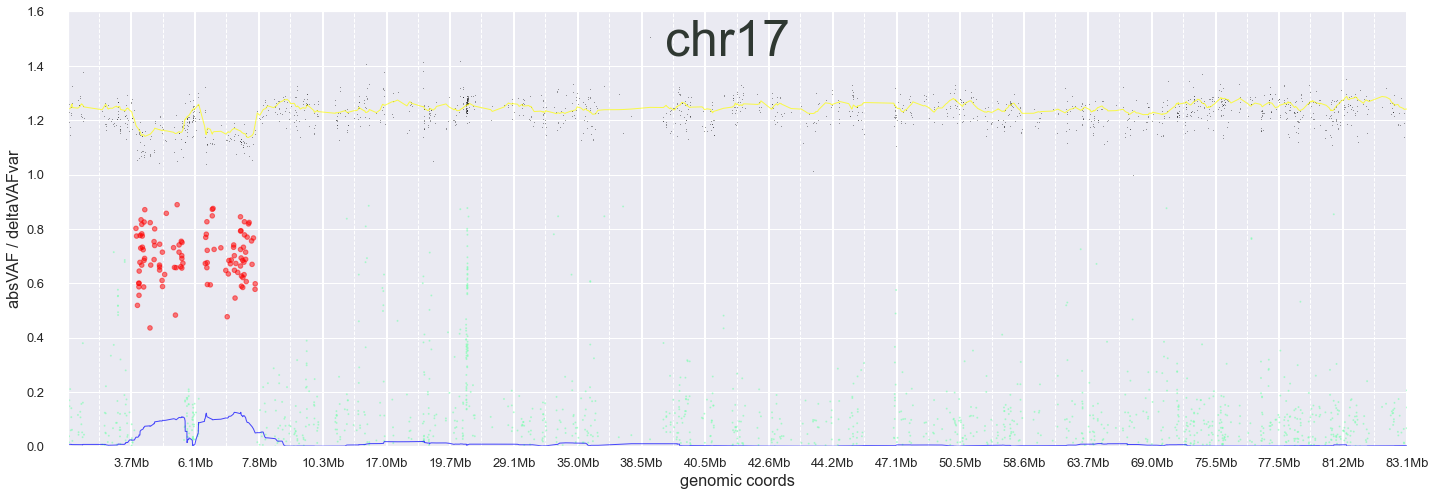

In [84]:
absvaf = dict(
        title='absVAF',
        plot_type='scatter',  # ['line', 'scatter']
        data='absVAF',
        plot_args=dict(
            c='dbscan',
            s='dbscan',
            alpha=.5,
            cmap='rainbow'
        )
    )

_ = plot_snp(df, snp_plots=[absvaf, absvafmean], cov_plots=[log2, log2mean], chroms=chroms, region='chr17', **fig_params)